# Gradient-free `CRP` parameter optimization

In [1]:
import pennylane as qml
from pennylane import numpy as np
from numpy.typing import NDArray

from matplotlib import pyplot as plt

## 1. Set up demo circuit

In [2]:
from circuits import sim_03

num_layers = 5
num_qubits = 4
circuit = sim_03(num_layers, num_qubits)

print(qml.draw(circuit)(np.random.random((num_layers, num_qubits, 3))))

0: ──RX(0.62)──RZ(0.33)─────────────────────╭RZ(0.01)──RX(0.60)──RZ(0.22)───────────╭RZ(0.39)
1: ──RX(0.98)──RZ(0.12)───────────╭RZ(0.02)─╰●─────────RX(0.88)──RZ(0.16)─╭RZ(0.75)─╰●───────
2: ──RX(0.34)──RZ(0.40)─╭RZ(0.13)─╰●─────────RX(0.21)──RZ(0.58)─╭RZ(0.06)─╰●─────────RX(0.16)
3: ──RX(0.19)──RZ(0.65)─╰●─────────RX(0.98)──RZ(0.80)───────────╰●─────────RX(0.53)──RZ(0.50)

───RX(1.00)──RZ(0.45)───────────╭RZ(0.37)──RX(0.82)──RZ(0.37)───────────╭RZ(1.00)──RX(0.09)
───RX(0.44)──RZ(0.62)─╭RZ(0.85)─╰●─────────RX(0.36)──RZ(0.06)─╭RZ(0.85)─╰●─────────RX(0.32)
───RZ(0.83)─╭RZ(0.96)─╰●─────────RX(0.53)──RZ(0.54)─╭RZ(0.06)─╰●─────────RX(0.28)──RZ(0.73)
────────────╰●─────────RX(0.63)──RZ(0.68)───────────╰●─────────RX(0.06)──RZ(0.13)──────────

───RZ(0.85)───────────╭RZ(0.59)─┤     
───RZ(0.54)─╭RZ(0.45)─╰●────────┤  <Z>
──╭RZ(0.66)─╰●──────────────────┤     
──╰●────────────────────────────┤     


## 2. Optimization loop

In [3]:
def create_univariate(circuit, params: NDArray[np.int_], param_index):
    def univariate(param_value):
        updated_params = params.copy()
        updated_params[param_index] = param_value
        return circuit(updated_params)
    
    return univariate

In [4]:
from reconstruction import reconstruct
from minimization import minimize_reconstruction

# in each iteration, reconstruct and optimize the univariate cost functions independently
def crotosolve_iteration(circuit, params, updates_dataset, debug = False):
    final_value = 42

    iterator = np.nditer(params, flags=['multi_index'])
    for old_param_value in iterator:
        param_index = iterator.multi_index
        if debug: print(f"Optimizing parameter {param_index}...")
        univariate = create_univariate(circuit, params, param_index)
        reconstruction, constants = reconstruct(univariate)
        new_param_value, new_fun_value = minimize_reconstruction(reconstruction, constants)
        if debug: print(f"Parameter update for {param_index} from {old_param_value} to {new_param_value} ({new_fun_value})")
        params[param_index] = new_param_value
        final_value = new_fun_value
        updates_dataset.append(new_fun_value)
    
    return final_value

In [5]:
def crotosolve(circuit, initial_params, debug = False):
    iterations_dataset = []
    updates_dataset = []

    params = initial_params.copy()
    for iteration in range(5):
        if debug: print(f" ===== ITERATION NO {iteration} =====")
        new_fun_value = crotosolve_iteration(circuit, params, updates_dataset, debug=debug)
        iterations_dataset.append(new_fun_value)
    
    return params, iterations_dataset, updates_dataset

rng = np.random.default_rng()
params = rng.random((5, 4, 3))

final_params, iterations_dataset, updates_dataset = crotosolve(circuit, params, debug=True)

 ===== ITERATION NO 0 =====
Optimizing parameter (0, 0, 0)...
Parameter update for (0, 0, 0) from 0.006156383650893105 to 6.242395943166038 (0.11311539721332636)
Optimizing parameter (0, 0, 1)...
Parameter update for (0, 0, 1) from 0.9188654398136437 to 5.635842488639405 (0.10241112954938741)
Optimizing parameter (0, 0, 2)...
Parameter update for (0, 0, 2) from 0.09887828362498396 to 3.617045673392244 (0.03365543216670479)
Optimizing parameter (0, 1, 0)...
Parameter update for (0, 1, 0) from 0.06833745610433106 to 7.9321555683023925 (-0.8250305323272537)
Optimizing parameter (0, 1, 1)...
Parameter update for (0, 1, 1) from 0.34975229115259654 to 6.626800555201493 (-0.8250464499542333)
Optimizing parameter (0, 1, 2)...
Parameter update for (0, 1, 2) from 0.09177506575183614 to 7.030635811689466 (-0.795745849972926)
Optimizing parameter (0, 2, 0)...
Parameter update for (0, 2, 0) from 0.8255815607597594 to 6.790627503036308 (-0.8011804655569894)
Optimizing parameter (0, 2, 1)...
Paramete

## 3. Print charts

Text(0.5, 1.0, 'Loss curve over crotosolve iterations')

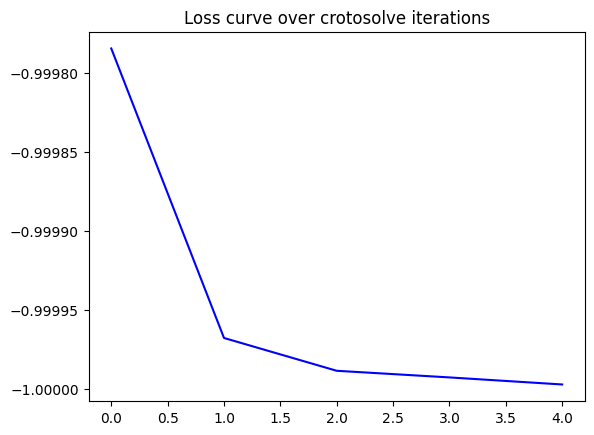

In [6]:

fig, ax = plt.subplots()
ax.plot(range(len(iterations_dataset)), iterations_dataset, 'b')
ax.set_title("Loss curve over crotosolve iterations")

Text(0.5, 1.0, 'Loss curve over circuit evaluations')

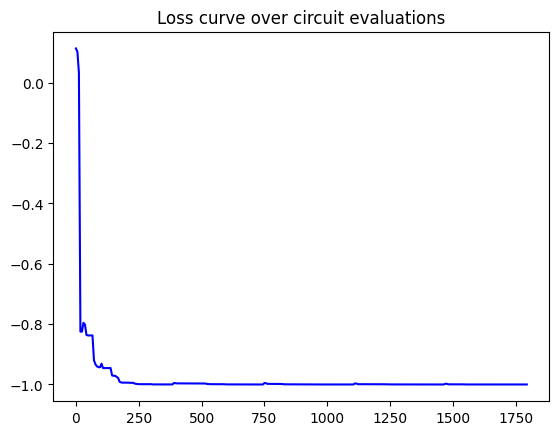

In [7]:

fig, ax = plt.subplots()
# multiply num of updates by 6 to get number of evaluations
ax.plot(6 * np.array(range(len(updates_dataset))), updates_dataset, 'b')
ax.set_title("Loss curve over circuit evaluations")